In [1]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm
from torch_geometric.datasets import TUDataset

import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
dataset = "AIDS"
data = TUDataset(".", name=dataset)

Extracting ./AIDS/AIDS.zip
Processing...
Done!


In [3]:
print(data)
print("number of classes: ",data.num_classes,"\t\t(active),(inactive)")
print("number of features: ",data.num_features)
print("number of edge labels: ",data.num_edge_labels)

AIDS(2000)
number of classes:  2 		(active),(inactive)
number of features:  38
number of edge labels:  3


In [4]:
data1 = data[1]

# extract edge list
edge_list = data1.edge_index.t().numpy()
print(edge_list[0:10])

[[0 1]
 [0 5]
 [1 0]
 [1 2]
 [1 6]
 [2 1]
 [2 3]
 [3 2]
 [3 4]
 [3 7]]


In [5]:
# extract edge attributes
edge_attr = data1.edge_attr.numpy()
print(edge_attr[0:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [6]:
import networkx as nx

# build the graph
graph1 = nx.Graph()

for i in range(len(edge_list)):
    u = edge_list[i][0]
    v = edge_list[i][1]
    graph1.add_edge(u,v,label=edge_attr[i])
    
print(graph1.edges(data=True))

[(0, 1, {'label': array([1., 0., 0.], dtype=float32)}), (0, 5, {'label': array([1., 0., 0.], dtype=float32)}), (1, 2, {'label': array([1., 0., 0.], dtype=float32)}), (1, 6, {'label': array([0., 1., 0.], dtype=float32)}), (5, 4, {'label': array([1., 0., 0.], dtype=float32)}), (5, 8, {'label': array([1., 0., 0.], dtype=float32)}), (2, 3, {'label': array([1., 0., 0.], dtype=float32)}), (3, 4, {'label': array([1., 0., 0.], dtype=float32)}), (3, 7, {'label': array([0., 1., 0.], dtype=float32)}), (4, 9, {'label': array([1., 0., 0.], dtype=float32)}), (4, 10, {'label': array([1., 0., 0.], dtype=float32)})]


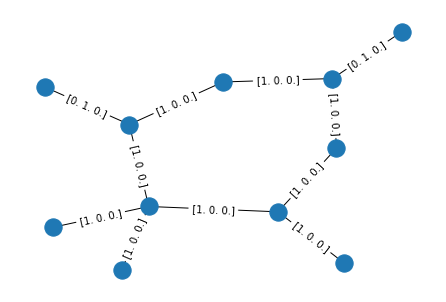

In [7]:
pos = nx.spring_layout(graph1)
nx.draw(graph1,pos)
nx.draw_networkx_edge_labels(graph1,pos,nx.get_edge_attributes(graph1,'label'))
plt.show()

In [8]:
data

AIDS(2000)

In [9]:
data = data[10]
data

Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])

In [10]:
np.random.seed(10)
# get the nodes
nodes = data.edge_index.t().numpy()
nodes = np.unique(list(nodes[:,0]) + list(nodes[:,1]))

np.random.shuffle(nodes) # shuffle node order
print(len(nodes))

76


In [11]:
# get train test and val sizes: (70% - 15% - 15%)
train_size = int(len(nodes)*0.7)
test_size = int(len(nodes)*0.85) - train_size
val_size = len(nodes) - train_size - test_size

In [12]:
# get train test and validation set of nodes
train_set = nodes[0:train_size]
test_set = nodes[train_size:train_size+test_size]
val_set = nodes[train_size+test_size:]


print(len(train_set),len(test_set),len(val_set))
print(len(train_set)+len(test_set)+len(val_set) == len(nodes))

print("train set\t",train_set[:10])
print("test set \t",test_set[:10])
print("val set  \t",val_set[:10])

53 11 12
True
train set	 [68 26 21  3 44 41  6 20  2 60]
test set 	 [13 73 51 49 14 67 70 33 58 43]
val set  	 [54 11 16 36 40  0  8 29 28 64]


In [13]:
# build test train val masks

train_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in test_set:
    test_mask[i] = 1.
    
val_mask = torch.zeros(len(nodes),dtype=torch.long, device=device)
for i in val_set:
    val_mask[i] = 1.
    
print("train mask \t",train_mask[0:15])
print("test mask  \t",test_mask[0:15])
print("val mask   \t",val_mask[0:15]) 

train mask 	 tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0])
test mask  	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])
val mask   	 tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0])


In [14]:
# remove from the data what do we not use.

print("befor\t\t",data)
data.x = None
data.edge_attr = None
data.y = None

befor		 Data(edge_index=[2, 166], x=[77, 38], edge_attr=[166, 3], y=[1])


In [15]:
# add masks
data.train_mask = train_mask
data.test_mask = test_mask
data.val_mask = val_mask

print("after\t\t",data)

after		 Data(edge_index=[2, 166], train_mask=[76], test_mask=[76], val_mask=[76])


In [16]:
device = 'cpu'

model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
             context_size=10, walks_per_node=10,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


In [17]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=10)
    return acc


for epoch in range(1, 101):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
        

Epoch: 10, Loss: 6.6570
Epoch: 20, Loss: 5.1668
Epoch: 30, Loss: 4.2925
Epoch: 40, Loss: 3.6700
Epoch: 50, Loss: 3.2754
Epoch: 60, Loss: 3.0840
Epoch: 70, Loss: 2.8979
Epoch: 80, Loss: 2.8554
Epoch: 90, Loss: 2.7820
Epoch: 100, Loss: 2.7624


In [18]:
z = model()
# from tensor to numpy
emb_128 = z.detach().cpu().numpy()

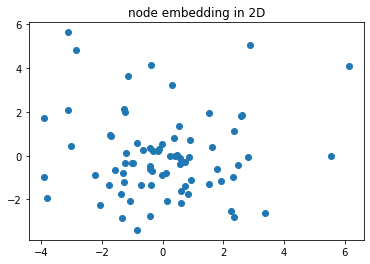

In [19]:
from sklearn.decomposition import PCA
# fit and transform using PCA
pca = PCA(n_components=2)
emb2d = pca.fit_transform(emb_128)


plt.title("node embedding in 2D")
plt.scatter(emb2d[:,0],emb2d[:,1])
plt.show()

In [20]:
# reload AIDS dataset 
# and pick the same graph


dataset = "AIDS"
data = TUDataset(".", name=dataset)
data = data[10]

In [21]:
# convert edge attributes from categorical to numerical
edge_attr_cat = data.edge_attr.numpy()
print("Categorical edge attributes:\n",edge_attr_cat[:3])

edge_attr = []
for i in edge_attr_cat:
    edge_attr.append(np.nonzero(i)[0][0])

print("\n\nNumerical edge attributes:\n",edge_attr[:3])

Categorical edge attributes:
 [[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


Numerical edge attributes:
 [0, 0, 1]


In [22]:
# compute edge embedding

edge_embedding = []
for u,v in data.edge_index.t():
    edge_embedding.append(np.mean([emb_128[u],emb_128[v]],0))

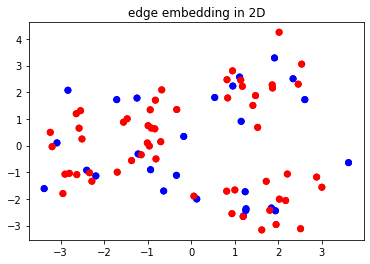

In [23]:
import pandas as pd
# fit and transform using PCA
pca = PCA(n_components=2)
edge_emb2d = pca.fit_transform(edge_embedding)



df = pd.DataFrame(dict(edge_att=edge_attr))
colors = {0:"red",1:"blue"}
plt.title("edge embedding in 2D")
plt.scatter(edge_emb2d[:,0],edge_emb2d[:,1],c=df.edge_att.map(colors))
plt.show()

# not so good but we are using PCA to reduce the dim from 128 to 2

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=7,random_state=10)


scores = cross_val_score(clf, edge_embedding, edge_attr, cv=10)
np.mean(scores)

0.7235294117647058

In [30]:
edge_attr

[0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0]